# input: 
seperate RFP and DAPI flourecent image pairs ( reffered to as red_img and blue_img)


In [13]:
# load images and set up paths


import numpy as np
from skimage.segmentation import expand_labels, watershed, find_boundaries
from scipy.ndimage import label as ndi_label, distance_transform_edt
import tifffile, cv2
from pathlib import Path
from skimage import morphology

notebook = Path(r"/home/phillip/documents/lysozyme/lysozyme-stain-quantification/docs/pipelineTheory.ipynb")

# go up to the project folder "lysozyme stain quantification"
project_root = notebook.parent.parent.parent



# Reuse existing 'pairs' if created earlier; otherwise build it quickly.
if 'pairs' not in globals():
    images_root = project_root / 'lysozyme images'
    red_files = sorted(list(images_root.rglob('*_RFP.tif')) + list(images_root.rglob('*_RFP.tiff')))
    def _match_blue(r_path: Path):
        stem = r_path.name
        if '_RFP.' not in stem:
            return None
        base = stem.split('_RFP.')[0]
        for ext in ['tif','tiff','TIF','TIFF']:
            cand = r_path.with_name(f'{base}_DAPI.{ext}')
            if cand.exists():
                return cand
        return None
    pairs = []
    for _r in red_files:
        b = _match_blue(_r)
        if b is not None:
            pairs.append((_r,b))
        if len(pairs) >= 30:
            break
    if not pairs:
        print('No RFP/DAPI pairs found. Aborting init cell.')

# Helper loaders (reuse if already defined).
if 'load_as_gray' not in globals():
    def load_as_gray(p: Path):
        arr = tifffile.imread(p)
        if arr.ndim == 3:
            if arr.shape[0] <= 4 and arr.shape[0] < arr.shape[-1]:
                arr = np.moveaxis(arr, 0, -1)
            if arr.shape[-1] in (3,4):
                arr = cv2.cvtColor(arr[..., :3].astype(np.uint8), cv2.COLOR_RGB2GRAY)
            else:
                arr = arr[...,0]
        return arr.astype(np.float32)
def build_rgb(red_gray, blue_gray):
    """
    Build RGB image from red and blue grayscale channels.
    
    Args:
        red_gray: Red channel as grayscale array
        blue_gray: Blue channel as grayscale array
    
    Returns:
        RGB image as uint8 numpy array
    """
    import numpy as np
    
    def to_u8(x):
        if x.dtype != np.uint8:
            lo, hi = np.nanmin(x), np.nanmax(x)
            if hi > lo:
                x = (x - lo) / (hi - lo) * 255.0
            else:
                x = np.zeros_like(x)
            return x.astype(np.uint8)
        return x
    
    r8 = to_u8(red_gray)
    b8 = to_u8(blue_gray)
    zeros = np.zeros_like(r8)
    
    return np.stack([r8, zeros, b8], axis=-1)
# Provided helper: minmax01
def minmax01(x, eps=1e-12):
    x = x.astype(float, copy=False)
    lo = np.min(x)
    hi = np.max(x)
    return (x - lo) / max(hi - lo, eps)

def _calculate_intensity_metrics( ws_labels, red_img, blue_img):
    """
    Calculate background tissue intensity and average crypt intensity
    before removing region 1 (background tissue).
    
    Args:
        ws_labels: Watershed labels array
        red_img: Red channel image
        blue_img: Blue channel image
    """
    # Calculate background tissue intensity (region 1) - optimized
    background_mask = (ws_labels == 1)
    background_tissue_intensity = 0.0
    if np.any(background_mask):
        # Use vectorized operations to avoid creating temporary arrays
        red_bg = red_img[background_mask]
        blue_bg = blue_img[background_mask]
        valid_mask = blue_bg > 1e-10  # Small threshold to avoid division by zero
        if np.any(valid_mask):
            background_tissue_intensity = np.mean(red_bg[valid_mask] / blue_bg[valid_mask])
    
    # Calculate average crypt intensity (all other regions excluding 0) - optimized
    crypt_mask = (ws_labels > 1)
    average_crypt_intensity = 0.0
    if np.any(crypt_mask):
        red_crypt = red_img[crypt_mask]
        blue_crypt = blue_img[crypt_mask]
        valid_mask = blue_crypt > 1e-10  # Small threshold to avoid division by zero
        if np.any(valid_mask):
            average_crypt_intensity = np.mean(red_crypt[valid_mask] / blue_crypt[valid_mask])
    
    # Store in debug info for access by the processor
    return (background_tissue_intensity,
            average_crypt_intensity)

def _remove_edge_touching_regions( labels):
    """
    Remove any labeled regions that touch the edges of the image - VECTORIZED VERSION.
    
    Args:
        labels: Labeled image array
        
    Returns:
        Filtered label array with edge-touching regions removed
    """
    height, width = labels.shape
    
    # Get unique labels excluding background
    unique_labels = np.unique(labels)
    unique_labels = unique_labels[unique_labels != 0]
    
    # Vectorized edge detection - get all edge pixels at once
    edge_mask = np.zeros_like(labels, dtype=bool)
    edge_mask[0, :] = True    # Top edge
    edge_mask[-1, :] = True   # Bottom edge
    edge_mask[:, 0] = True    # Left edge
    edge_mask[:, -1] = True   # Right edge
    
    # Find all labels that touch edges in one operation
    edge_labels = np.unique(labels[edge_mask])
    edge_labels = edge_labels[edge_labels != 0]  # Remove background
    

    # Vectorized removal - create mask for non-edge labels
    keep_mask = ~np.isin(labels, edge_labels)
    filtered_labels = labels * keep_mask  # Removes edge labels, sets them to 0
    
    # Vectorized relabeling - get remaining labels and create lookup table
    remaining_labels = np.unique(filtered_labels)
    remaining_labels = remaining_labels[remaining_labels != 0]
    
    if len(remaining_labels) > 0:
        # Create vectorized lookup table for relabeling
        max_label = remaining_labels.max()
        lookup = np.zeros(max_label + 1, dtype=labels.dtype)
        
        for new_id, old_id in enumerate(sorted(remaining_labels), start=1):
            lookup[old_id] = new_id
        
        # Apply vectorized relabeling
        final_labels = np.where(filtered_labels > 0, lookup[filtered_labels], 0)
    else:
        final_labels = filtered_labels
    
    return final_labels



# pipeline:
    (red_image, blue_img) -> 
    grayscale ->  


## extractor_run: ->
    red_img & blue_img -> %%it looks like i dont normalize them%%
    prep grayscale masks: ->
        mask_r_dilation = np.maximum(blue, red) 
        mask_r_erosion = np.minimum(blue, red)
        %%these are np/ basicaly images of where each pixel value comes from whichever wins there%%
    


Text(0.5, 1.0, 'Blue channel (DAPI)')

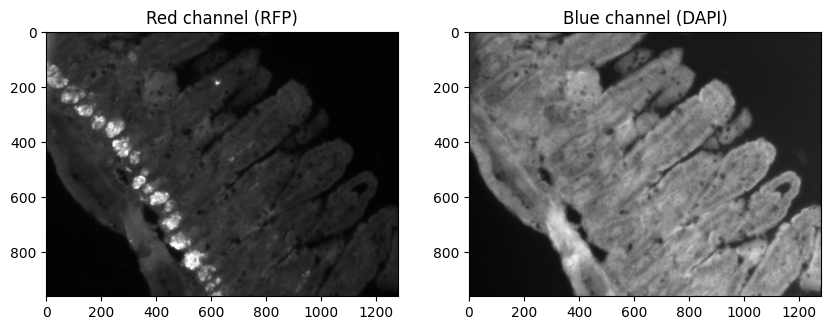

In [22]:
import matplotlib.pyplot as plt
# pick a random pair from the first `max_samples` (change 30 to your desired cap)

max_samples = min(len(pairs), 30)
idx = np.random.randint(0, max_samples)
red_img = (load_as_gray(pairs[idx][0]))
blue_img = (load_as_gray(pairs[idx][1]))
plt, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(red_img, cmap='gray')
ax[0].set_title('Red channel (RFP)')
ax[1].imshow(blue_img, cmap='gray')
ax[1].set_title('Blue channel (DAPI)')

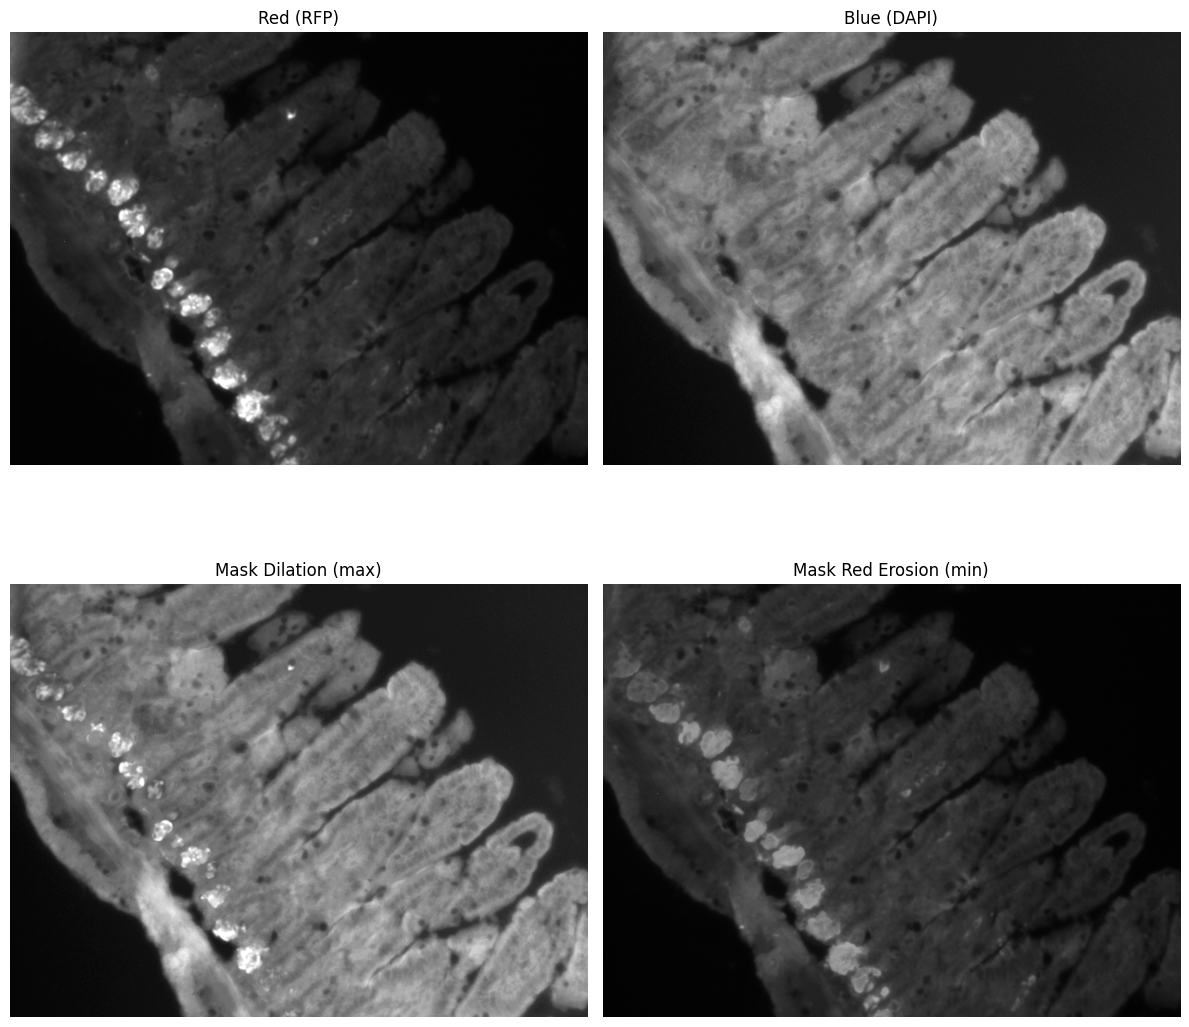

In [23]:
import numpy as np
from skimage.segmentation import watershed
from scipy.ndimage import label as ndi_label, distance_transform_edt
import cv2
from skimage import morphology
import matplotlib.pyplot as plt


# Build RGB display image to match notebook exactly
disp = build_rgb(red_img, blue_img)

# Extract red and blue channels from the RGB display (this is key!)
# This matches the notebook: red = disp[...,0].astype(np.float32)
red = disp[..., 0].astype(np.float32)
blue = disp[..., 2].astype(np.float32)


# Simple morphological reconstruction style differences (matching notebook exactly)
mask_r_dilation = np.maximum(blue, red)
mask_r_erosion = np.minimum(blue, red)

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes[0,0].imshow(red, cmap='gray'); axes[0,0].set_title('Red (RFP)')
axes[0,1].imshow(blue, cmap='gray'); axes[0,1].set_title('Blue (DAPI)')
axes[1,0].imshow(mask_r_dilation, cmap='gray'); axes[1,0].set_title('Mask Dilation (max)')
axes[1,1].imshow(mask_r_erosion, cmap='gray'); axes[1,1].set_title('Mask Red Erosion (min)')
for ax in axes.ravel():
    ax.axis('off')
plt.tight_layout()
plt.show()


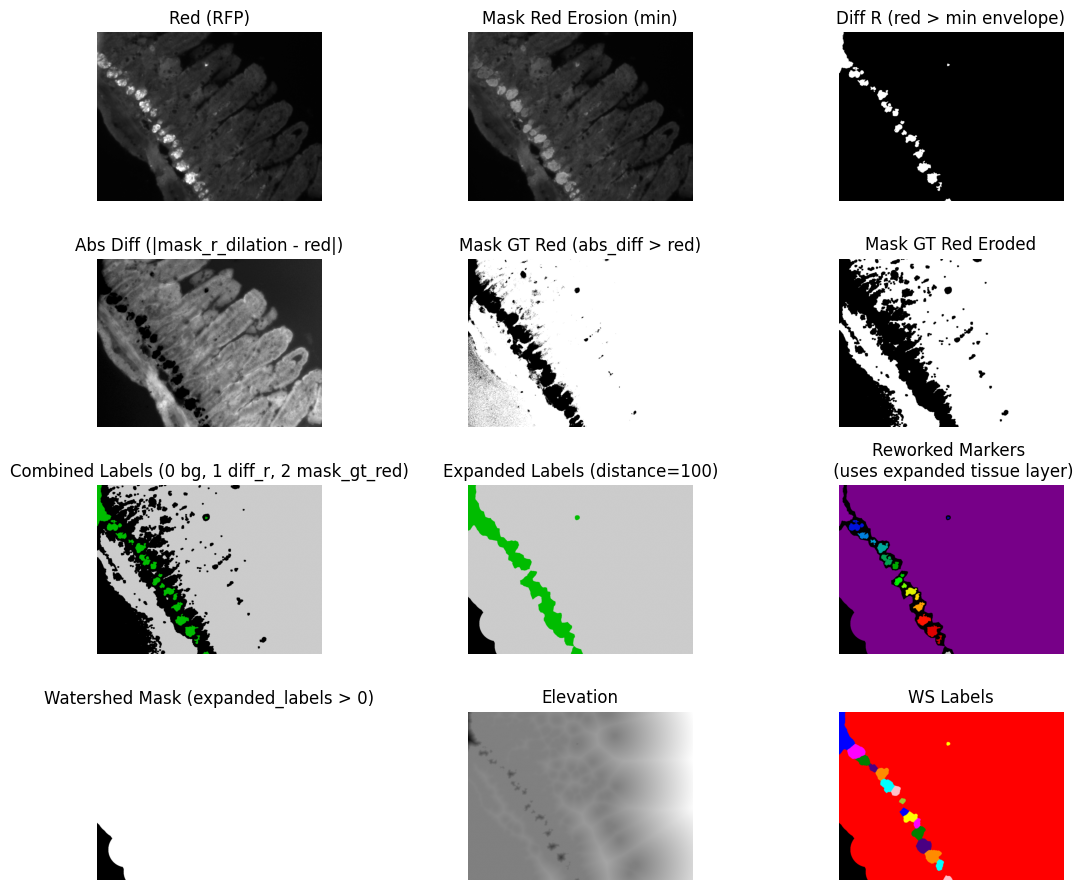

Background Tissue Intensity: 0.6969960331916809
Average Crypt Intensity: 2.161648988723755


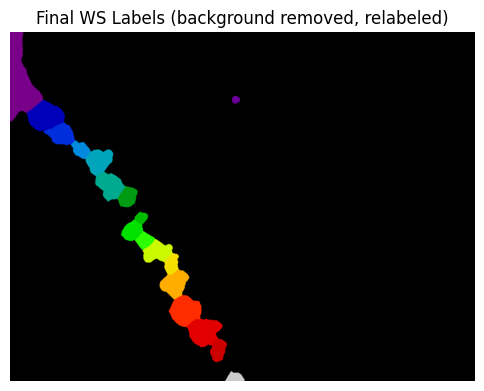

In [45]:
from skimage.color import label2rgb
# diff_r: red stronger than min envelope (exact notebook logic)
diff_r = red > blue #mask_r_erosion swapped, bc unneded


diff_r = morphology.binary_erosion(diff_r, footprint=np.ones((3, 3)))
diff_r = morphology.remove_small_objects(diff_r, min_size=100)




fig2, ax2 = plt.subplots(4, 3, figsize=(4*3, 3*3))
ax2[0,0].imshow(red, cmap='gray'); ax2[0,0].set_title('Red (RFP)')
ax2[0,1].imshow(mask_r_erosion, cmap='gray'); ax2[0,1].set_title('Mask Red Erosion (min)')
ax2[0,2].imshow(diff_r, cmap='gray'); ax2[0,2].set_title('Diff R (red > min envelope)')
# Secondary mask using absolute difference (exact notebook logic)
# abs_diff = np.abs(mask_r_dilation - red)
mask_gt_red = blue > 2*red


# Erode the secondary mask (exact notebook parameters)
erosion_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6, 6))
mask_u8 = (mask_gt_red.astype(np.uint8) * 255)
mask_eroded_u8 = cv2.erode(mask_u8, erosion_kernel, iterations=2)
mask_gt_red_eroded = mask_eroded_u8.astype(bool)

## show abs_diff and mask_gt_red and mask_gt_red_eroded
ax2[1,0].imshow(mask_r_dilation - red, cmap='gray'); ax2[1,0].set_title('Abs Diff (|mask_r_dilation - red|)')
ax2[1,1].imshow(mask_gt_red, cmap='gray'); ax2[1,1].set_title('Mask GT Red (abs_diff > red)')
ax2[1,2].imshow(mask_gt_red_eroded, cmap='gray'); ax2[1,2].set_title('Mask GT Red Eroded')

# Build combined_labels (0 bg, 1 diff_r, 2 mask_gt_red) - exact notebook
combined_labels = np.zeros_like(diff_r, dtype=int)
combined_labels[mask_gt_red_eroded] = 2
combined_labels[diff_r] = 1


# Expand labels (exact notebook distance=100)
expanded_labels = expand_labels(combined_labels, distance=100)


# Markers from diff_r (exact notebook logic)
labeled_diff_r, _ = ndi_label(diff_r != 0)

## show combined_labels, expanded_labels, labeled_diff_r
ax2[2,0].imshow(combined_labels, cmap='nipy_spectral'); ax2[2,0].set_title('Combined Labels (0 bg, 1 diff_r, 2 mask_gt_red)')
ax2[2,1].imshow(expanded_labels, cmap='nipy_spectral'); ax2[2,1].set_title('Expanded Labels (distance=100)')


# Reworked markers array (exact notebook logic)
reworked = np.zeros_like(expanded_labels, dtype=np.int32)
reworked[expanded_labels == 2] = 1  # entire class 2 region => marker 1
mask_copy = (expanded_labels != 2) & (labeled_diff_r != 0) # expanded_labels != 2 is background 0 and crypts 1, labeled_diff_r != 0 is labeled crypts from diff_r
reworked[mask_copy] = labeled_diff_r[mask_copy] + 1

## show reworked
ax2[2,2].imshow(reworked, cmap='nipy_spectral'); ax2[2,2].set_title('Reworked Markers \n (uses expanded tissue layer)')


# Watershed mask (exact notebook logic)
mask_ws = expanded_labels > 0



# Elevation: attract to class 2, repel from class 1 (exact notebook)
elevation = (
    minmax01(distance_transform_edt(combined_labels == 2))
    - minmax01(distance_transform_edt(combined_labels == 1))
)


# Apply watershed (exact notebook logic)
ws_labels = watershed(elevation, markers=reworked, mask=mask_ws)


# show watershed mask, elevation, and ws_labels
ax2[3,0].imshow(mask_ws, cmap='gray'); ax2[3,0].set_title('Watershed Mask (expanded_labels > 0)')
ax2[3,1].imshow(elevation, cmap='gray'); ax2[3,1].set_title('Elevation')
ax2[3,2].imshow(label2rgb(ws_labels)); ax2[3,2].set_title('WS Labels')
for ax2 in ax2.ravel():
    ax2.axis('off')
plt.tight_layout()
plt.show()

# Calculate background and crypt intensities before removing region 1
ws_labels_pre = ws_labels.copy()
a,b = _calculate_intensity_metrics(ws_labels_pre, red_img, blue_img)
# print results
print(f"Background Tissue Intensity: {a}")
print(f"Average Crypt Intensity: {b}")
# Remove background label (1) and relabel others sequentially starting from 1
ws_labels[ws_labels == 1] = 0
ws_labels[ws_labels > 1] = ws_labels[ws_labels > 1] - 1
# finaly show the final ws_labels
plt.figure(figsize=(6,6))
plt.imshow(ws_labels, cmap='nipy_spectral')
plt.title('Final WS Labels (background removed, relabeled)')
plt.axis('off')
plt.show()




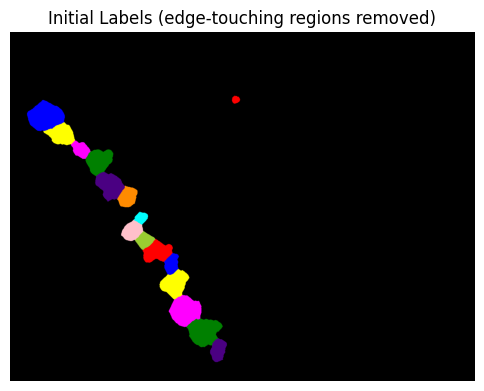

In [25]:
from skimage.color import label2rgb
# Remove regions that touch the image edges
initial_labels = _remove_edge_touching_regions(ws_labels)
# show initial_labels
plt.figure(figsize=(6,6))
plt.imshow(label2rgb(initial_labels))
plt.title('Initial Labels (edge-touching regions removed)')
plt.axis('off')
plt.show()

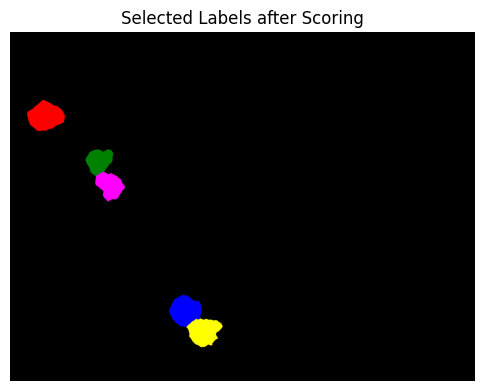

In [33]:
# Apply SCORING STRATEGY - Quality-based region selection
scoring_weights = {
    'circularity': 0.35,    # Most important - want circular regions
    'area': 0.25,           # Second - want consistent sizes
    'line_fit': 0.15,       # Moderate - want aligned regions
    'red_intensity': 0.15,  # Moderate - want bright regions
    'com_consistency': 0.10 # Least - center consistency
}

import numpy as np
import pandas as pd
from scipy.ndimage import center_of_mass
from sklearn.linear_model import LinearRegression
from skimage.measure import regionprops, perimeter
import matplotlib.pyplot as plt
class ScoringSelector:
    """Selector for choosing the best regions based on scoring criteria instead of merging."""
    
    def __init__(self, label_img, raw_img=None, debug=False, max_regions=5, weights=None):
        """
        Initialize the scoring selector.
        
        Args:
            label_img: Labeled image array with detected regions
            raw_img: Raw red channel image for quality assessment
            debug: Whether to enable debug output
            max_regions: Maximum number of regions to select (default: 5)
            weights: Dict of scoring weights (default weights used if None)
        """
        self.label_img = label_img.copy()
        self.raw_img = raw_img
        self.debug = debug
        self.max_regions = max_regions
        
        # Default weights if none provided
        self.weights = weights if weights is not None else {
            'circularity': 0.35,    # Most important - want circular regions
            'area': 0.25,           # Second - want consistent sizes
            'line_fit': 0.15,       # Moderate - want aligned regions
            'red_intensity': 0.15,  # Moderate - want bright regions
            'com_consistency': 0.10 # Least - center consistency
        }
        
        # Results storage
        self.properties_df = None
        self.selected_labels = None
        self.scoring_history = []

    def calculate_region_properties(self):
        """Calculate comprehensive properties for each detected region - VECTORIZED VERSION"""
        if self.debug:
            unique_labels = np.unique(self.label_img)
            print(f"[SCORING DEBUG] Input label array has {len(unique_labels)} unique labels: {unique_labels}")
        
        # Get all region properties in one call - much faster than looping
        regions = regionprops(self.label_img, intensity_image=self.raw_img)
        
        if len(regions) == 0:
            return pd.DataFrame()
        
        # Extract properties vectorized
        properties = []
        for region in regions:
            if self.debug:
                print(f"[SCORING DEBUG] Processing label {region.label}: area = {region.area} pixels")
            
            # Red intensity calculation (if raw image provided)
            if self.raw_img is not None:
                # Use mean_intensity from regionprops and convert to total/per_area
                total_red_intensity = region.mean_intensity * region.area
                red_intensity_per_area = region.mean_intensity
            else:
                total_red_intensity = 0
                red_intensity_per_area = 0
            
            # Circularity measure using regionprops perimeter
            circularity = 4 * np.pi * region.area / (region.perimeter**2) if region.perimeter > 0 else 0
            
            properties.append({
                'label_id': region.label,
                'area': region.area,
                'physical_com': region.centroid,
                'red_intensity_per_area': red_intensity_per_area,
                'total_red_intensity': total_red_intensity,
                'circularity': circularity,
                'perimeter': region.perimeter
            })
        
        return pd.DataFrame(properties)

    def calculate_line_fit_deviation(self, properties_df):
        """Calculate how far each detection center is from line of best fit through all centers,
        normalized by region size (radius approximation) - VECTORIZED VERSION"""
        if len(properties_df) < 2:
            properties_df['distance_from_line'] = 0
            properties_df['normalized_line_distance'] = 0
            return properties_df
        
        # Get physical centers as array - vectorized
        centers = np.array(list(properties_df['physical_com']))
        
        # Fit line through centers
        X = centers[:, 1].reshape(-1, 1)  # x coordinates
        y = centers[:, 0]  # y coordinates
        
        reg = LinearRegression().fit(X, y)
        
        # Vectorized distance calculation
        m = reg.coef_[0]
        b = reg.intercept_
        
        # Calculate distances for all points at once using broadcasting
        x_coords = centers[:, 1]
        y_coords = centers[:, 0]
        distances = np.abs(m * x_coords - y_coords + b) / np.sqrt(m**2 + 1)
        
        # Vectorized normalization by radius approximation
        areas = properties_df['area'].values
        radius_approx = np.sqrt(areas / 2)
        radius_approx[radius_approx == 0] = 1  # Avoid division by zero
        normalized_distances = distances / radius_approx
        
        properties_df['distance_from_line'] = distances
        properties_df['normalized_line_distance'] = normalized_distances
        return properties_df

    def score_regions(self, properties_df):
        """
        Calculate quality scores for all regions.
        Lower scores are better (easier to rank by ascending order).
        """
        if len(properties_df) == 0:
            return properties_df
        
        # Score components (normalized to 0-1, where 0 is best)
        
        # 1. Circularity score (higher circularity is better, so invert)
        max_circularity = properties_df['circularity'].max()
        if max_circularity > 0:
            properties_df['circularity_score'] = 1 - (properties_df['circularity'] / max_circularity)
        else:
            properties_df['circularity_score'] = 1.0
        
        # 2. Area score (larger areas are better, so invert)
        max_area = properties_df['area'].max()
        if max_area > 0:
            properties_df['area_score'] = 1 - (properties_df['area'] / max_area)
        else:
            properties_df['area_score'] = 0.0
        
        # 3. Line fit score (closer to line is better, using normalized distance)
        max_line_dist = properties_df['normalized_line_distance'].max()
        if max_line_dist > 0:
            properties_df['line_fit_score'] = properties_df['normalized_line_distance'] / max_line_dist
        else:
            properties_df['line_fit_score'] = 0.0
        
        # 4. Red intensity score (higher intensity is better, so invert)
        # This is already calculated as red_intensity_per_area = total_red_intensity / area
        max_red_intensity = properties_df['red_intensity_per_area'].max()
        if max_red_intensity > 0:
            properties_df['red_intensity_score'] = 1 - (properties_df['red_intensity_per_area'] / max_red_intensity)
        else:
            properties_df['red_intensity_score'] = 1.0
        
        # Composite quality score (weighted combination, lower is better)
        # Use weights passed during initialization - drop COM consistency
        properties_df['quality_score'] = (
            self.weights.get('circularity', 0.4) * properties_df['circularity_score'] +
            self.weights.get('area', 0.3) * properties_df['area_score'] +
            self.weights.get('line_fit', 0.2) * properties_df['line_fit_score'] +
            self.weights.get('red_intensity', 0.1) * properties_df['red_intensity_score']
        )
        
        # Store scoring history for debugging
        if self.debug:
            self.scoring_history.append({
                'max_circularity': max_circularity,
                'max_area': max_area,
                'max_line_dist': max_line_dist,
                'max_red_intensity': max_red_intensity,
                'weights': self.weights
            })
        
        return properties_df.sort_values('quality_score')

    def select_best_regions(self, properties_df):
        """Select the best N regions based on quality scores"""
        
        # Sort by quality score (ascending - lower is better)
        sorted_df = properties_df.sort_values('quality_score')
        
        # Select top N regions
        n_to_select = min(self.max_regions, len(sorted_df))
        best_regions = sorted_df.head(n_to_select)
        
        if self.debug:
            print(f"[SCORING DEBUG] Selected top {n_to_select} regions out of {len(sorted_df)} total")
            print(f"[SCORING DEBUG] Selected labels: {best_regions['label_id'].tolist()}")
            print(f"[SCORING DEBUG] Quality scores: {best_regions['quality_score'].tolist()}")
            
            # Print detailed scoring breakdown for top regions
            for idx, row in best_regions.iterrows():
                print(f"[SCORING DEBUG] Label {row['label_id']}: "
                      f"area={row['area']:.1f}, circ={row['circularity']:.3f}, "
                      f"red_int={row['red_intensity_per_area']:.2f}, "
                      f"line_dist={row['normalized_line_distance']:.2f}, "
                      f"final_score={row['quality_score']:.3f}")
        
        return best_regions['label_id'].tolist()

    def create_filtered_labels(self, selected_label_ids):
        """Create new label array with only selected regions - VECTORIZED VERSION"""
        
        if self.debug:
            print(f"[SCORING DEBUG] Creating filtered labels from {len(selected_label_ids)} selected regions")
            print(f"[SCORING DEBUG] Selected IDs: {selected_label_ids}")
        
        # Create new label array with only selected regions - vectorized approach
        filtered_labels = np.zeros_like(self.label_img)
        
        # Create mapping for vectorized relabeling
        old_to_new = {old_id: new_id for new_id, old_id in enumerate(selected_label_ids, start=1)}
        
        # Vectorized relabeling using fancy indexing
        if selected_label_ids:
            # Create a lookup table for all possible label values
            max_label = max(selected_label_ids) if selected_label_ids else 0
            lookup = np.zeros(max_label + 1, dtype=filtered_labels.dtype)
            
            for old_id, new_id in old_to_new.items():
                lookup[old_id] = new_id
                if self.debug:
                    pixels_count = np.sum(self.label_img == old_id)
                    print(f"[SCORING DEBUG] Relabeled {old_id} -> {new_id}, {pixels_count} pixels")
            
            # Apply vectorized lookup - much faster than loops
            mask = np.isin(self.label_img, selected_label_ids)
            filtered_labels[mask] = lookup[self.label_img[mask]]
        
        if self.debug:
            print(f"[SCORING DEBUG] Filtered label array unique labels: {np.unique(filtered_labels)}")
        
        return filtered_labels

    def select(self):
        """
        Main selection function that scores all regions and selects the best ones.
        
        Returns:
            Filtered label array containing only the best regions
        """
        if self.debug:
            print("Starting quality-based region selection...")
        
        # Step 1: Calculate region properties
        self.properties_df = self.calculate_region_properties()
        
        if len(self.properties_df) == 0:
            if self.debug:
                print("[SCORING DEBUG] No regions found to score")
            return np.zeros_like(self.label_img)
        
        # Step 2: Calculate line fit deviations
        self.properties_df = self.calculate_line_fit_deviation(self.properties_df)
        
        # Step 3: Score all regions
        self.properties_df = self.score_regions(self.properties_df)
        
        if self.debug:
            print(f"[SCORING DEBUG] Scored {len(self.properties_df)} regions")
        
        # Step 4: Select best regions
        self.selected_labels = self.select_best_regions(self.properties_df)
        
        # Step 5: Create filtered label array
        filtered_labels = self.create_filtered_labels(self.selected_labels)
        
        if self.debug:
            original_count = len(np.unique(self.label_img)) - 1
            selected_count = len(np.unique(filtered_labels)) - 1
            print(f"[SCORING DEBUG] Selection complete: {original_count} -> {selected_count} regions")
        
        return filtered_labels

    def get_debug_info(self):
        """Return debug information about the selection process"""
        return {
            'properties_df': self.properties_df,
            'selected_labels': self.selected_labels,
            'scoring_history': self.scoring_history,
            'original_regions': len(np.unique(self.label_img)) - 1,
            'selected_regions': len(self.selected_labels) if self.selected_labels else 0
        }

    def plot_scoring_results(self, save_path=None):
        """Plot scoring results for visualization"""
        if self.properties_df is None:
            print("No scoring results to plot. Run select() first.")
            return
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()
        
        # Plot individual score components - removed com_consistency_score
        score_columns = ['circularity_score', 'area_score', 'line_fit_score', 
                        'red_intensity_score', 'quality_score']
        
        # Add a basic info plot for the 6th subplot
        score_columns.append('area')  # Show actual area values
        
        for i, col in enumerate(score_columns):
            if col in self.properties_df.columns:
                self.properties_df.plot.scatter(x='label_id', y=col, ax=axes[i], alpha=0.7)
                axes[i].set_title(f'{col.replace("_", " ").title()}')
                axes[i].set_xlabel('Label ID')
                axes[i].set_ylabel('Score' if 'score' in col else 'Value')
                
                # Highlight selected regions
                if self.selected_labels:
                    selected_df = self.properties_df[self.properties_df['label_id'].isin(self.selected_labels)]
                    axes[i].scatter(selected_df['label_id'], selected_df[col], 
                                  c='red', s=100, alpha=0.8, marker='x', linewidth=3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            plt.close()
        else:
            plt.show()
selector = ScoringSelector(initial_labels, red_img, max_regions=5, weights=scoring_weights)
selected_labels = selector.select()
# show selected_labels
plt.figure(figsize=(6,6))
plt.imshow(label2rgb(selected_labels))
plt.title('Selected Labels after Scoring')
plt.axis('off')
plt.show()